In [1]:
import os
from pathlib import Path
import logging
import random
import itertools
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST,
    PREDICTION,
    SAVED_MODELS
)

device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


In [3]:
# Reduce the dataset to contain only those regulation
# that map to a single quality topic
# Problem reduces to multi-class classification
df = df[df[TARGET].apply(lambda x: len(x)) == 1].copy()
df.reset_index(drop=True, inplace=True)

In [4]:
features = Features(config)
df_features = features.build(df)

df_features.head(3)

2022-12-06 20:11:33,844 - capstone.utils.utils - INFO - func:clean took: 2.74 sec
2022-12-06 20:11:34,253 - capstone.utils.utils - INFO - func:fit took: 3.15 sec
2022-12-06 20:11:35,607 - capstone.utils.utils - INFO - func:clean took: 1.35 sec
2022-12-06 20:11:35,776 - capstone.utils.utils - INFO - func:transform took: 1.52 sec
2022-12-06 20:11:35,777 - capstone.utils.utils - INFO - func:fit_transform took: 4.68 sec
2022-12-06 20:11:35,932 - capstone.utils.utils - INFO - func:clean took: 0.15 sec
2022-12-06 20:11:35,952 - capstone.utils.utils - INFO - func:transform took: 0.17 sec
2022-12-06 20:11:35,965 - capstone.utils.utils - INFO - func:build took: 4.87 sec


,Text,Standard mapping?,Original Text,audit inspection,calibration,change controls,clinical research,controled substances,csv,data management,...,word__unique device,word__upon request,word__use device,word__used manufacture,word__used production,word__validation process,word__way ensures,word__written procedure,word__year date,Split
0,commencement clinical trial member state take ...,[clinical research],Commencement of a clinical trial […] Member St...,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Development
1,production management packaging operation proc...,[labeling and packaging operations],Production Management […] Packaging Operations...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Development
2,entering agreement investigator institution co...,[clinical research],Before entering an agreement with an investiga...,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Development


In [5]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
Y_test = test[features.mlb.classes_].copy()

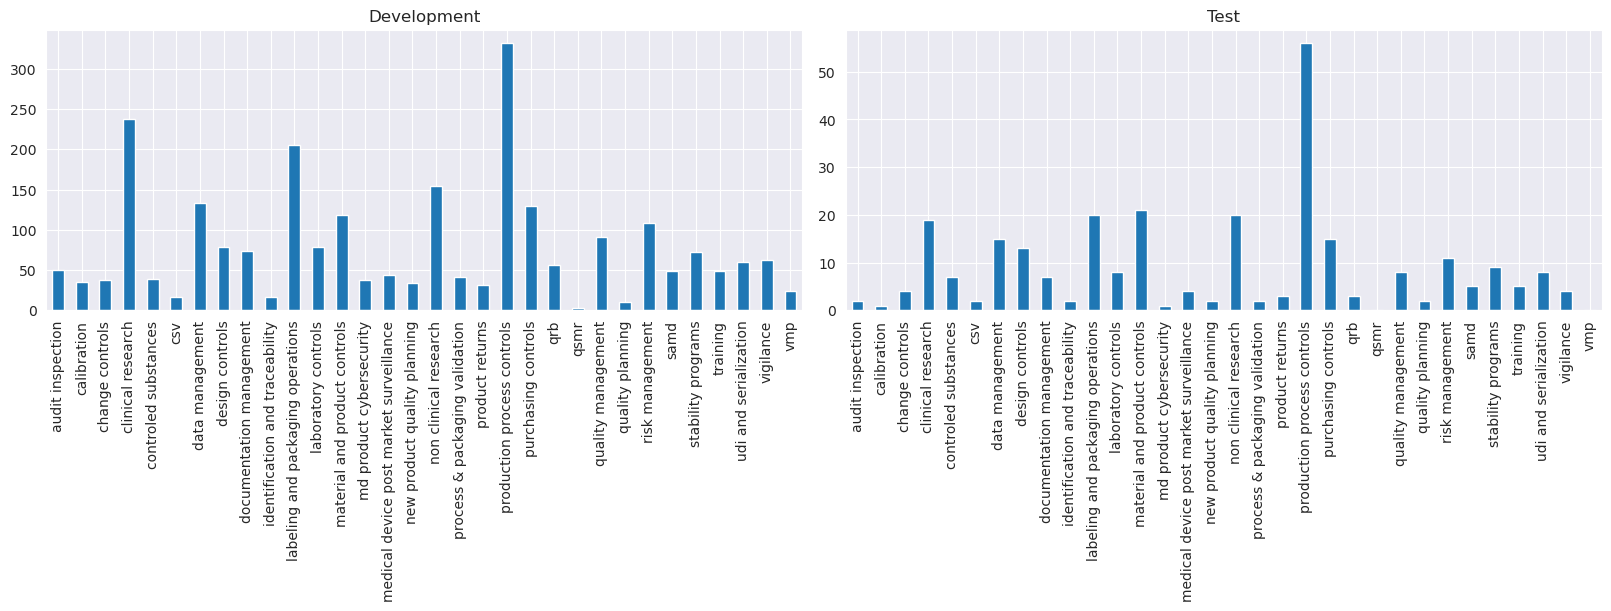

In [6]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
Y_dev.sum(axis=0).plot.bar(ax=ax[0])
Y_test.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Development")
ax[1].set_title("Test");

In [7]:
train, val, _, _ = train_test_split(
    dev, dev[features.mlb.classes_].to_numpy(), test_size=.1, shuffle=True, random_state=64
)

Y_train = train[features.mlb.classes_].copy()
Y_val = val[features.mlb.classes_].copy()

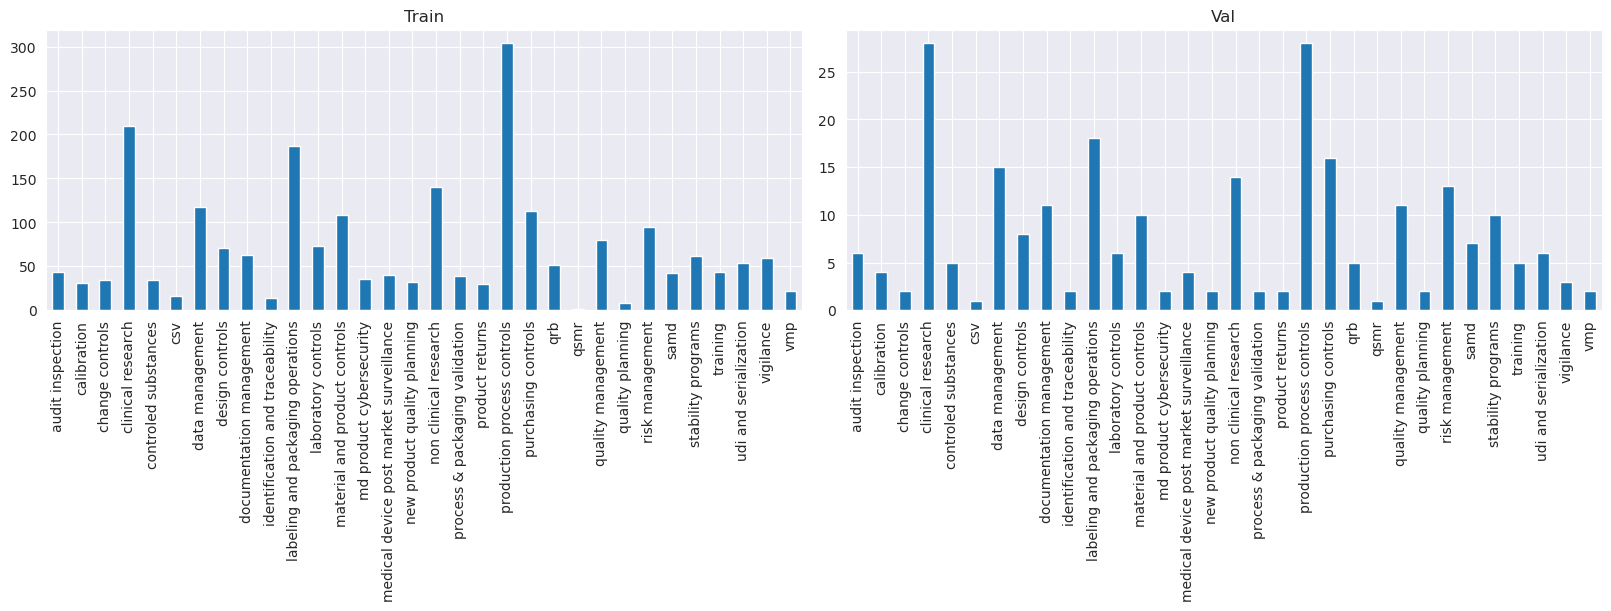

In [8]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
Y_train.sum(axis=0).plot.bar(ax=ax[0])
Y_val.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Train") 
ax[1].set_title("Val");

In [9]:
class JJDataset(Dataset):
  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: AutoTokenizer, 
    max_length: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_length = max_length
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    row = self.data.iloc[index]
    text = row[ORIGINAL_TEXT]
    target = row[features.mlb.classes_]

    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_length,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_token_type_ids=True,
      return_tensors='pt'
    )

    return {
        "input_ids": inputs["input_ids"].flatten(),
        "attention_mask": inputs["attention_mask"].flatten(),
        "token_type_ids": inputs["token_type_ids"].flatten(),
        "target": torch.FloatTensor(target)
    }


In [10]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

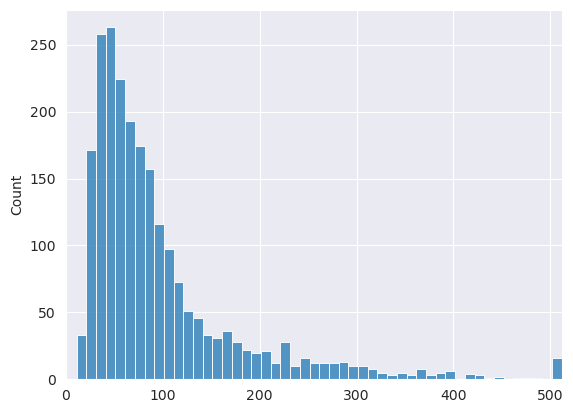

In [11]:
token_counts = []
for _, row in train.iterrows():
    tokens = tokenizer.encode(
        row[ORIGINAL_TEXT],
        max_length=512,
        truncation=True
    )
    token_counts.append(len(tokens))

sns.histplot(token_counts)
plt.xlim([0, 512]);

In [12]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = AutoModel.from_pretrained(BERT_MODEL_NAME)
        self.l2 = nn.Dropout(0.3)
        self.l3 = nn.Linear(self.l1.config.hidden_size, len(features.mlb.classes_))

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.l1(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        out = self.l2(out.pooler_output)
        out = self.l3(out)
        return out

model = Model()
model.to(device);

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
MAX_TOKEN_COUNT = 256
TRAIN_BATCH = 32
VALID_BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-04
NUM_WORKERS = 0

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
saved_models_path = Path(os.path.join(data.current_path, SAVED_MODELS))
saved_models_path.mkdir(parents=True, exist_ok=True)

In [15]:
train_dataset = JJDataset(
    train,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
valid_dataset = JJDataset(
    val,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKERS)

In [16]:
# Move model to device
model.to(device)
# Lists to keep the losses and evaluation scores at the end of each epoch
train_loss, valid_loss = list(), list()
for epoch in range(EPOCHS):
    # Dummy lists to keep the losses and evaluation scores at the end of each iteration
    # (one batch forward and backward process)
    train_batch_loss, valid_batch_loss = list(), list()
    # Training mode
    model.train()
    for i, item in enumerate(train_loader):
        # Move input to device
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)
        # Forward pass
        out = model(input_ids, attention_mask, token_type_ids)
        # Calculate loss
        loss = criterion(out, target)
        # Reset gradients
        optimizer.zero_grad()
        # Backward pass (backpropogation)
        loss.backward()
        # Update weights
        optimizer.step()
        # Collect loss and evaluation scores
        train_batch_loss.append(loss.item())
        message = \
            f"EPOCH:{epoch+1}/{EPOCHS}, " + \
            f"step:{i+1}/{len(train_loader)}, " + \
            f"loss={loss.item()}"
        print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    train_loss.append(np.array(train_batch_loss).mean())
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        for i, item in enumerate(valid_loader):
            # Move input to device
            input_ids = item["input_ids"].to(device, dtype=torch.long)
            attention_mask = item["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
            target = item["target"].to(device, dtype=torch.float)
            # Forward pass
            out = model(input_ids, attention_mask, token_type_ids)
            # Calculate loss
            loss = criterion(out, target)
            valid_batch_loss.append(loss.item())
            message = \
                f"EPOCH:{epoch+1}/{EPOCHS}, " + \
                f"step:{i+1}/{len(valid_loader)}, " + \
                f"loss={loss.item()}"
            print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    valid_loss.append(np.array(valid_batch_loss).mean())
    message = \
        f"EPOCH:{epoch+1}/{EPOCHS} - " + \
        f"Training Loss: {train_loss[-1]}, " + \
        f"Validation Loss: {valid_loss[-1]}"
    print("\r", message)
    # Save model
    state = f"epoch_{epoch+1:03}.pth"
    state_dict_path = os.path.join(saved_models_path, state)
    torch.save(model.state_dict(), state_dict_path)

 EPOCH:1/20 - Training Loss: 0.21748579618796496, Validation Loss: 0.13081571832299232
 EPOCH:2/20 - Training Loss: 0.13110789184419203, Validation Loss: 0.12684098072350025
 EPOCH:3/20 - Training Loss: 0.11497955569918726, Validation Loss: 0.09219451528042555
 EPOCH:4/20 - Training Loss: 0.08099233931009199, Validation Loss: 0.0692302929237485
 EPOCH:5/20 - Training Loss: 0.055732313858371386, Validation Loss: 0.052619502414017916
 EPOCH:6/20 - Training Loss: 0.039732336683172574, Validation Loss: 0.0427457676269114
 EPOCH:7/20 - Training Loss: 0.030047579261828477, Validation Loss: 0.04440572904422879
 EPOCH:8/20 - Training Loss: 0.02553582094399862, Validation Loss: 0.04424810269847512
 EPOCH:9/20 - Training Loss: 0.022296089600299447, Validation Loss: 0.040149468928575516
 EPOCH:10/20 - Training Loss: 0.01691086314828463, Validation Loss: 0.03863789979368448
 EPOCH:11/20 - Training Loss: 0.013749821039415161, Validation Loss: 0.03951477655209601
 EPOCH:12/20 - Training Loss: 0.0117

In [17]:
best_epoch = np.argmin(valid_loss) + 1
print(f"Best epoch: {best_epoch}")
state = f"epoch_{best_epoch:03}.pth"
state_dict_path = os.path.join(saved_models_path, state)
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

Best epoch: 12


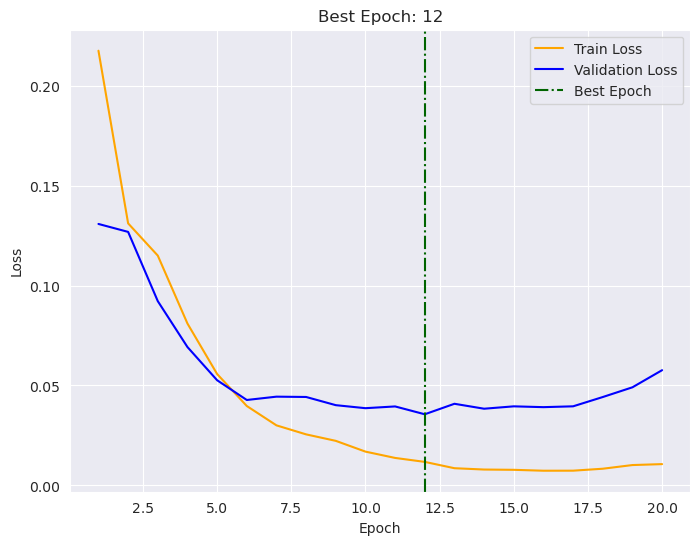

In [18]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS+1), train_loss, label="Train Loss", color="orange")
plt.plot(range(1, EPOCHS+1), valid_loss, label="Validation Loss", color="blue")
plt.axvline(x=best_epoch, label="Best Epoch", color="darkgreen", linestyle="dashdot")
plt.xlabel("Epoch")
plt.ylabel(f"Loss")
plt.title(f"Best Epoch: {best_epoch}")
plt.legend(loc="upper right");

In [19]:
valid_dataset = JJDataset(
    val,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []
with torch.no_grad():
    for i, item in enumerate(valid_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

y_true_val = np.array(y_true).astype(int)
y_pred_probab_val = np.array(y_pred_probab)

In [347]:
y_pred_val = np.eye(y_true_val.shape[1])[y_pred_probab_val.argmax(axis=1)]

In [349]:
eval = CustomEvaluation()

eval.compute_sample_wise_metrics(y_true=y_true_val, y_pred=y_pred_val)

Hamming Loss    0.008964
Accuracy        0.856574
Precision       0.856574
Recall          0.856574
F1 Score        0.856574
F2 Score        0.856574
dtype: float64

In [23]:
test_dataset = JJDataset(
    test,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []

with torch.no_grad():
    for i, item in enumerate(test_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

y_true_test = np.array(y_true).astype(int)
y_pred_probab_test = np.array(y_pred_probab)

In [351]:
y_pred_test = np.eye(y_true_test.shape[1])[y_pred_probab_test.argmax(axis=1)]

eval.compute_sample_wise_metrics(y_true=y_true_test, y_pred=y_pred_test)

Hamming Loss    0.008961
Accuracy        0.856631
Precision       0.856631
Recall          0.856631
F1 Score        0.856631
F2 Score        0.856631
dtype: float64

In [354]:
eval.compute_label_wise_metrics(
    y_true=y_true_test,
    y_pred=y_pred_test,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,F2 Score,Development Samples,Test Samples
audit inspection,0.500000,1.000000,0.666667,0.833333,50,2
calibration,0.500000,1.000000,0.666667,0.833333,35,1
change controls,1.000000,0.750000,0.857143,0.789474,37,4
clinical research,0.900000,0.947368,0.923077,0.937500,238,19
controled substances,1.000000,1.000000,1.000000,1.000000,39,7
csv,0.333333,0.500000,0.400000,0.454545,17,2
data management,0.866667,0.866667,0.866667,0.866667,133,15
design controls,0.818182,0.692308,0.750000,0.714286,79,13
documentation management,1.000000,0.857143,0.923077,0.882353,74,7
identification and traceability,0.400000,1.000000,0.571429,0.769231,16,2


In [356]:
save_to = os.path.join(data.reports_path, "bert-multiclass.pth")
torch.save(model.state_dict(), save_to)